In [9]:
!pip install shapely

Active code page: 1252
     ---------------------------------------- 1.4/1.4 MB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

AttributeError: partially initialized module 'cv2' has no attribute 'dnn' (most likely due to a circular import)

## Get data

In [31]:
import glob

#Combining all CSV files
file_paths = [
    "./bus_1.csv",
    "./bus_2.csv",
    "./bus_3.csv",
    "./bus_4.csv",
    "./bus_5.csv",
    "./bus_6.csv",
    "./bus_7.csv",
    "./bus_8.csv",
    "./bus_9.csv",
    "./bus_10.csv",
    "./bus_11.csv",
    "./bus_12.csv",
    "./bus_13.csv",
    "./bus_14.csv",
    "./bus_15.csv",
    "./bus_16.csv",
    "./bus_17.csv",
    "./bus_18.csv",
    "./bus_19.csv",
    "./bus_20.csv",
    "./bus_21.csv",
    "./bus_22.csv",
    "./bus_23.csv",
    "./bus_24.csv",
    "./bus_25.csv",
    "./bus_28.csv",
    "./bus_29.csv",
    "./bus_31.csv",
    "./bus_32.csv",
    "./bus_34.csv",
    "./bus_35.csv",
    "./bus_36.csv",
    "./bus_37.csv",
    "./bus_39.csv",
    "./bus_40.csv",
    "./bus_41.csv",
    "./bus_44.csv",
    "./bus_46.csv",
    "./bus_47.csv",
    "./bus_48.csv",
    "./bus_50.csv",
    "./bus_51.csv",
    "./bus_52.csv",
    "./bus_53.csv",
    "./bus_54.csv",
    "./bus_56.csv",
    "./bus_60.csv",
    "./bus_61.csv",
    "./bus_64.csv",    
    "./bus_70.csv",
    "./bus_71.csv",
    "./bus_72.csv",
    "./bus_73.csv",
    "./bus_80.csv",
    "./bus_81.csv",
    "./bus_120.csv",
]



In [32]:
bus_cols = ['bus_id', 'route', 'time', 'latitude', 'longitude', 'angle', 'iteration']
bus_stops_cols = ['id', 'longitude', 'latitude']

# Read CSV files (adjust file paths as needed)
bus_df = pd.concat([pd.read_csv(f, header=None, names=bus_cols) for f in file_paths], ignore_index=True)
bus_stops_df = pd.read_csv('bus_stops.csv', header=None, names=bus_stops_cols)

# Convert the time column in bus_df to datetime
bus_df['time'] = pd.to_datetime(bus_df['time'])

              route      latitude     longitude         angle     iteration
count  65059.000000  65059.000000  65059.000000  65059.000000  65059.000000
mean      29.459952     51.144341     71.442828    176.190941    331.979219
std       20.279096      0.040488      0.039301    103.169208    193.458021
min        1.000000     51.027416     71.359520      0.078207      1.000000
25%       11.000000     51.125946     71.412120     90.000000    166.000000
50%       24.000000     51.146230     71.432780    179.614679    332.000000
75%       53.000000     51.173032     71.471825    276.613358    499.000000
max       64.000000     51.251423     71.567970    359.923829    732.000000


In [33]:
bus_df.head()

,bus_id,route,time,latitude,longitude,angle,iteration
0,Z005,1,2021-04-07 09:04:54,51.175392,71.437780,347.089001,1
1,Z075,1,2021-04-07 09:04:51,51.163017,71.407524,263.769415,1
2,Z122,1,2021-04-07 09:01:37,51.200470,71.455960,288.393394,1
3,Z112,1,2021-04-07 09:04:48,51.175600,71.437460,170.678579,1
4,Z019,1,2021-04-07 09:04:44,51.165340,71.427284,83.496622,1


In [51]:
bus_df.describe()

,latitude,longitude,angle
count,319950.000000,319950.000000,319950.000000
mean,51.152085,71.440859,180.740492
std,0.031637,0.053801,101.304204
min,51.027416,71.208160,0.061538
25%,51.130764,71.410590,96.628255
50%,51.154495,71.434970,180.000000
75%,51.175360,71.474120,277.833527
max,51.251423,71.686210,359.931971


In [59]:
bus_stops_df.describe()

,id,longitude,latitude
count,496.000000,496.000000,496.000000
mean,248.500000,71.426739,51.149971
std,143.327132,0.064445,0.040228
min,1.000000,71.003548,50.963938
25%,124.750000,71.400387,51.127677
50%,248.500000,71.421422,51.151735
75%,372.250000,71.461954,51.180280
max,496.000000,71.647621,51.311285


In [52]:
bus_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319950 entries, 0 to 319951
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   bus_id     319950 non-null  object        
 1   route      319950 non-null  object        
 2   time       319950 non-null  datetime64[ns]
 3   latitude   319950 non-null  float64       
 4   longitude  319950 non-null  float64       
 5   angle      319950 non-null  float64       
 6   iteration  319950 non-null  object        
 7   point      319950 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 22.0+ MB


In [35]:
# Check missing values
print(bus_df.isnull().sum())

bus_id       0
route        0
time         0
latitude     0
longitude    0
angle        0
iteration    0
dtype: int64


### Create Spatial Points
We use Shapely to create point geometries.

In [60]:
bus_df['point'] = bus_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
bus_stops_df['point'] = bus_stops_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

In [61]:
bus_stops_df.head()

,id,longitude,latitude,point
0,1.0,71.474053,51.150886,POINT (71.474053 51.1508857)
1,2.0,71.474363,51.151565,POINT (71.474363 51.1515648)
2,3.0,71.469581,51.150385,POINT (71.4695812 51.150385)
3,4.0,71.469641,51.149631,POINT (71.4696413 51.1496312)
4,5.0,71.470542,51.148479,POINT (71.4705425 51.148479)


In [62]:
bus_df.head()

,bus_id,route,time,latitude,longitude,angle,iteration,point
0,Z005,1,2021-04-07 09:04:54,51.175392,71.437780,347.089001,1,POINT (71.43778 51.1753922)
1,Z075,1,2021-04-07 09:04:51,51.163017,71.407524,263.769415,1,POINT (71.4075241 51.1630173)
2,Z122,1,2021-04-07 09:01:37,51.200470,71.455960,288.393394,1,POINT (71.45596 51.20047)
3,Z112,1,2021-04-07 09:04:48,51.175600,71.437460,170.678579,1,POINT (71.43746 51.1756)
4,Z019,1,2021-04-07 09:04:44,51.165340,71.427284,83.496622,1,POINT (71.4272842 51.16534)


### Identify Arrival Events at Bus Stops
For each bus stop, we create a buffer (e.g. radius = 0.0008) and find all bus records that fall inside.
We also record the bus stop id with each matching bus record.

In [64]:
test_stop = bus_stops_df.iloc[0]
test_buffer = test_stop['point'].buffer(0.0008)
test_matches = bus_df[bus_df['point'].apply(lambda p: test_buffer.contains(p))]
print("Bus records within buffer for test stop:", test_matches)

Bus records within buffer for test stop:        bus_id route                time   latitude  longitude       angle  \
8712     A511     3 2021-04-07 09:17:02  51.150810  71.474090  188.130102   
8851     A528     3 2021-04-07 09:32:05  51.151485  71.474290    8.827495   
8909     A508     3 2021-04-07 09:39:59  51.151560  71.474330   44.557983   
9001     A540     3 2021-04-07 09:51:03  51.150757  71.474110  178.475725   
9049     A499     3 2021-04-07 09:58:29  51.151474  71.474310   17.696275   
...       ...   ...                 ...        ...        ...         ...   
312552   A266    73 2021-04-07 21:29:27  51.150577  71.474130  171.327091   
312556   A057    73 2021-04-07 21:29:15  51.150650  71.474260   50.808142   
312564   A057    73 2021-04-07 21:29:47  51.151310  71.474335    6.457361   
312658   A002    73 2021-04-07 21:45:25  51.150750  71.474106  180.268009   
312890   A012    73 2021-04-07 22:19:30  51.151320  71.474300    5.069420   

       iteration                  

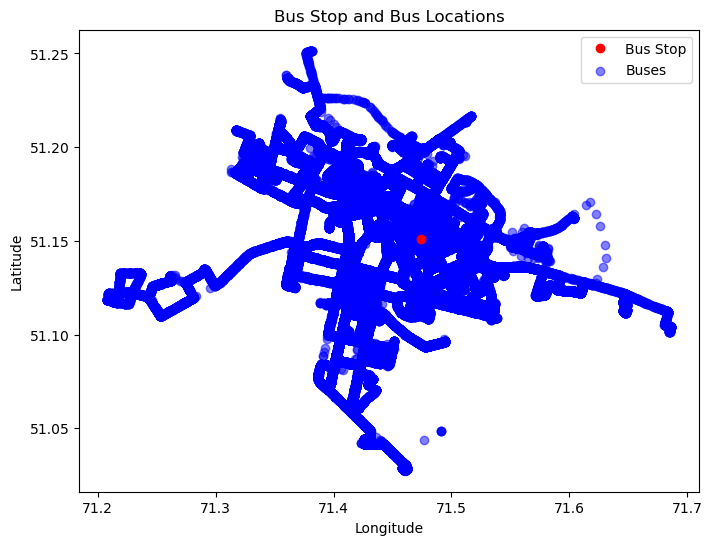

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
# Plot bus stop
plt.plot(test_stop['longitude'], test_stop['latitude'], 'ro', label='Bus Stop')
# Plot bus points
plt.scatter(bus_df['longitude'], bus_df['latitude'], c='blue', label='Buses', alpha=0.5)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Bus Stop and Bus Locations")
plt.show()

In [66]:
buffer_distance = 0.0008

arrival_events = []

for idx, stop in bus_stops_df.iterrows():
    stop_id = stop['id']
    stop_point = stop['point']
    # create buffer around the bus stop
    stop_buffer = stop_point.buffer(buffer_distance)
    
    # identify bus records where the bus point is within the buffer
    mask = bus_df['point'].apply(lambda p: stop_buffer.contains(p))
    arrivals_at_stop = bus_df[mask].copy()
    
    if not arrivals_at_stop.empty:
        arrivals_at_stop['bus_stop_id'] = stop_id
        # calculate the distance from the bus point to the stop
        arrivals_at_stop['distance_to_stop'] = arrivals_at_stop['point'].apply(lambda p: p.distance(stop_point))
        arrival_events.append(arrivals_at_stop)

In [67]:
if arrival_events:
    arrivals_df = pd.concat(arrival_events, ignore_index=True)
else:
    raise ValueError("No arrival events found. Check your CSV data and buffer settings.")

In [69]:
arrivals_df.head()

,bus_id,route,time,latitude,longitude,angle,iteration,point,bus_stop_id,distance_to_stop
0,A511,3,2021-04-07 09:17:02,51.150810,71.47409,188.130102,11,POINT (71.47409 51.15081),1.0,0.000084
1,A528,3,2021-04-07 09:32:05,51.151485,71.47429,8.827495,24,POINT (71.47429 51.1514854),1.0,0.000645
2,A508,3,2021-04-07 09:39:59,51.151560,71.47433,44.557983,30,POINT (71.47433 51.15156),1.0,0.000729
3,A540,3,2021-04-07 09:51:03,51.150757,71.47411,178.475725,39,POINT (71.47411 51.1507568),1.0,0.000141
4,A499,3,2021-04-07 09:58:29,51.151474,71.47431,17.696275,45,POINT (71.47431 51.151474),1.0,0.000642


### Compute Delay Between Arrivals
For each bus stop, we sort the arrivals by time and compute the delay in minutes (difference between the next arrival and the current arrival)

In [70]:
arrivals_df = arrivals_df.sort_values(by=['bus_stop_id', 'time'])

# get time of the next arrival for each stop
arrivals_df['next_time'] = arrivals_df.groupby('bus_stop_id')['time'].shift(-1)

# compute the delay in minutes
arrivals_df['delay'] = (arrivals_df['next_time'] - arrivals_df['time']).dt.total_seconds() / 60.0

# drop rows with null delay
arrivals_df = arrivals_df.dropna(subset=['delay']).reset_index(drop=True)

We add a feature for the time of day (minutes since midnight) and encode categorical features. Here we encode the 'route' and the 'bus_stop_id' as numeric categories.

In [71]:
arrivals_df['time_of_day'] = arrivals_df['time'].dt.hour * 60 + arrivals_df['time'].dt.minute

# encode categorical features
arrivals_df['route_encoded'] = arrivals_df['route'].astype('category').cat.codes
arrivals_df['bus_stop_encoded'] = arrivals_df['bus_stop_id'].astype('category').cat.codes

print("Sample arrival events with computed delay:")
print(arrivals_df.head())

Sample arrival events with computed delay:
  bus_id route                time   latitude  longitude       angle  \
0   G022    14 2021-04-07 09:07:15  51.150738  71.474110  179.487392   
1   E021    40 2021-04-07 09:07:19  51.150852  71.474060  181.073714   
2   G022    14 2021-04-07 09:09:27  51.150257  71.474144  185.209147   
3   A456    73 2021-04-07 09:09:40  51.150932  71.474100  180.155454   
4   C101    31 2021-04-07 09:13:19  51.151460  71.474120  179.630791   

  iteration                         point  bus_stop_id  distance_to_stop  \
0         3   POINT (71.47411 51.1507378)          1.0          0.000159   
1         3   POINT (71.47406 51.1508522)          1.0          0.000034   
2         5  POINT (71.474144 51.1502571)          1.0          0.000635   
3         5    POINT (71.4741 51.1509323)          1.0          0.000066   
4         8     POINT (71.47412 51.15146)          1.0          0.000578   

            next_time     delay  time_of_day  route_encoded  bus_st

## Models

In [72]:
features = ['iteration', 'time_of_day', 'route_encoded', 'bus_stop_encoded', 'angle', 'distance_to_stop']
target = 'delay'

X = arrivals_df[features]
y = arrivals_df[target]

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
import tensorflow.keras.backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [84]:
data_seq = arrivals_df[features].values
target_seq = arrivals_df[target].values

def create_sequences(data, target, window_size):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size):
        X_seq.append(data[i:i+window_size])
        y_seq.append(target[i+window_size])
    return np.array(X_seq), np.array(y_seq)

window_size = 5
X_seq, y_seq = create_sequences(data_seq, target_seq, window_size)

X_seq = X_seq.astype(np.float32)
y_seq = y_seq.astype(np.float32)

print("Sequence data shape:", X_seq.shape, y_seq.shape)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
# Convert to float32
num_features = X_seq.shape[2]

Sequence data shape: (131610, 5, 6) (131610,)


In [88]:
# Build the CNN model
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, num_features)),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model_cnn.compile(optimizer='adam', 
                  loss='mse', 
                  metrics=[root_mean_squared_error, 'mae'])
model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 4, 64)               │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 3, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │           9,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,789 (73.39 KB)

 Trainable params: 18,789 (73.39 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Train the CNN model
history_cnn = model_cnn.fit(X_train_seq, y_train_seq, epochs=20, validation_split=0.2, verbose=1)

# Evaluate the CNN model
loss_cnn, rmse_cnn, mae_cnn = model_cnn.evaluate(X_test_seq, y_test_seq)

Epoch 1/20
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 253.6602 - mae: 5.9948 - root_mean_squared_error: 7.8903 - val_loss: 33.1100 - val_mae: 2.6345 - val_root_mean_squared_error: 4.9223
Epoch 2/20
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 29.4623 - mae: 3.0584 - root_mean_squared_error: 4.9268 - val_loss: 30.4482 - val_mae: 2.5725 - val_root_mean_squared_error: 4.7279
Epoch 3/20
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 24.4608 - mae: 2.7411 - root_mean_squared_error: 4.5739 - val_loss: 34.0673 - val_mae: 2.4907 - val_root_mean_squared_error: 4.8061
Epoch 4/20
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 27.7835 - mae: 2.7258 - root_mean_squared_error: 4.5242 - val_loss: 29.9324 - val_mae: 2.6153 - val_root_mean_squared_error: 4.5381
Epoch 5/20
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 26.6110 - mae: 2.6734 - root_mean_squared_error: 4.4720 - val_loss: 29.6365 - val_mae: 2.6676 - val_root_mean_squared_error: 4.5164
Epoch 6/20
2633/2633 ━━━

In [95]:
print("CNN Model Test Loss (MSE), RMSE, MAE:", loss_cnn)

CNN Model Test Loss (MSE), RMSE, MAE: [28.688692092895508, 4.824051856994629, 2.394691228866577]


In [91]:
model_rnn = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, num_features)),
    Dense(1)
])

model_rnn.compile(optimizer='adam', 
                  loss='mse', 
                  metrics=[root_mean_squared_error, 'mae'])
model_rnn.summary()

C:\Users\adel0\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
history_rnn = model_rnn.fit(X_train_seq, y_train_seq, epochs=20, validation_split=0.2, verbose=1)

Epoch 1/20
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 658.2847 - mae: 10.6199 - root_mean_squared_error: 14.3776 - val_loss: 35.5437 - val_mae: 2.8069 - val_root_mean_squared_error: 5.0834
Epoch 2/20
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 28.3412 - mae: 2.9461 - root_mean_squared_error: 4.7556 - val_loss: 33.2241 - val_mae: 2.5977 - val_root_mean_squared_error: 4.9099
Epoch 3/20
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 27.3648 - mae: 2.8518 - root_mean_squared_error: 4.6626 - val_loss: 30.8511 - val_mae: 3.3298 - val_root_mean_squared_error: 4.9272
Epoch 4/20
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 28.5702 - mae: 2.8489 - root_mean_squared_error: 4.7692 - val_loss: 28.7924 - val_mae: 2.8435 - val_root_mean_squared_error: 4.6272
Epoch 5/20
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 25.7527 - mae: 2.7721 - root_mean_squared_error: 4.6574 - val_loss: 29.7556 - val_mae: 2.5233 - val_root_mean_squared_error: 4.8378
Epoch 6/20
2633/2633 ━

In [94]:
loss_rnn, rmse_rnn, mae_rnn = model_rnn.evaluate(X_test_seq, y_test_seq)
print("RNN Model Test Loss (MSE):", loss_rnn)
print("RNN Model Test RMSE:", rmse_rnn)
print("RNN Model Test MAE:", mae_rnn)

823/823 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 49.8946 - mae: 2.5327 - root_mean_squared_error: 5.0690
RNN Model Test Loss (MSE): 26.756853103637695
RNN Model Test RMSE: 4.81976318359375
RNN Model Test MAE: 2.4961485862731934


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Model evaluation metrics
metrics = ["MSE", "RMSE", "MAE"]

# CNN model results
cnn_results = [loss_cnn, rmse_cnn, mae_cnn]

# RNN model results
rnn_results = [loss_rnn, rmse_rnn, mae_rnn]

# Bar width
bar_width = 0.3
x = np.arange(len(metrics))

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, cnn_results, bar_width, label="CNN", color='b')
plt.bar(x + bar_width/2, rnn_results, bar_width, label="RNN", color='g')

# Labels and title
plt.xlabel("Metrics")
plt.ylabel("Error")
plt.title("Comparison of CNN and RNN Model Test Loss")
plt.xticks(ticks=x, labels=metrics)
plt.legend()

# Show plot
plt.show()


NameError: name 'loss_cnn' is not defined